In [24]:
!pip install opendatasets

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import cv2
from google.colab.patches import cv2_imshow
import os
from tqdm import tqdm
import glob as gb
import opendatasets as od

In [26]:
od.download("https://www.kaggle.com/datasets/fanconic/skin-cancer-malignant-vs-benign")

Skipping, found downloaded files in "./skin-cancer-malignant-vs-benign" (use force=True to force download)


In [27]:
os.listdir("/content/skin-cancer-malignant-vs-benign/train")

['malignant', 'benign']

In [28]:
train_dir = "/content/skin-cancer-malignant-vs-benign/train/"
test_dir = "/content/skin-cancer-malignant-vs-benign/test/"

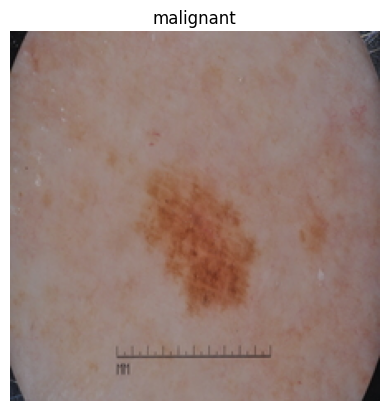

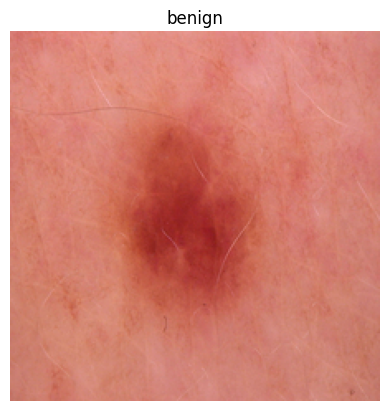

In [29]:
for i in os.listdir(train_dir):
  for j in os.listdir(train_dir+i):
    im = cv2.imread(train_dir+i+"/"+j)
    im = cv2.cvtColor(im,cv2.COLOR_BGR2RGB)
    im = cv2.resize(im, (224,224))
    plt.imshow(im)
    plt.axis("off")
    plt.title(i)
    plt.show()
    break

In [30]:
X_train = list()
y_train = list()
image_class = {"benign":0, "malignant":1}
for i in os.listdir(train_dir):
  class_dir = train_dir+i+'/'
  for j in tqdm(os.listdir(class_dir)):
    origin_image = cv2.imread(class_dir+j)
    RGB_image = cv2.cvtColor(origin_image,cv2.COLOR_BGR2RGB)
    resize_image = cv2.resize(RGB_image, (96,96))
    X_train.append(resize_image)
    y_train.append(image_class[i])

100%|██████████| 1440/1440 [00:04<00:00, 352.02it/s]


In [31]:
y_train = np.array(y_train)
X_train = np.array(X_train)

In [32]:
X_test = list()
y_test = list()
image_class = {"benign":0, "malignant":1}
for i in os.listdir(test_dir):
  class_dir = test_dir+i+'/'
  for j in tqdm(os.listdir(class_dir)):
    origin_image = cv2.imread(class_dir+j)
    RGB_image = cv2.cvtColor(origin_image, cv2.COLOR_BGR2RGB)
    resize_image = cv2.resize(RGB_image, (96,96))
    X_test.append(resize_image)
    y_test.append(image_class[i])


100%|██████████| 360/360 [00:00<00:00, 436.88it/s]


In [33]:
X_test = np.array(X_test)
y_test = np.array(y_test)

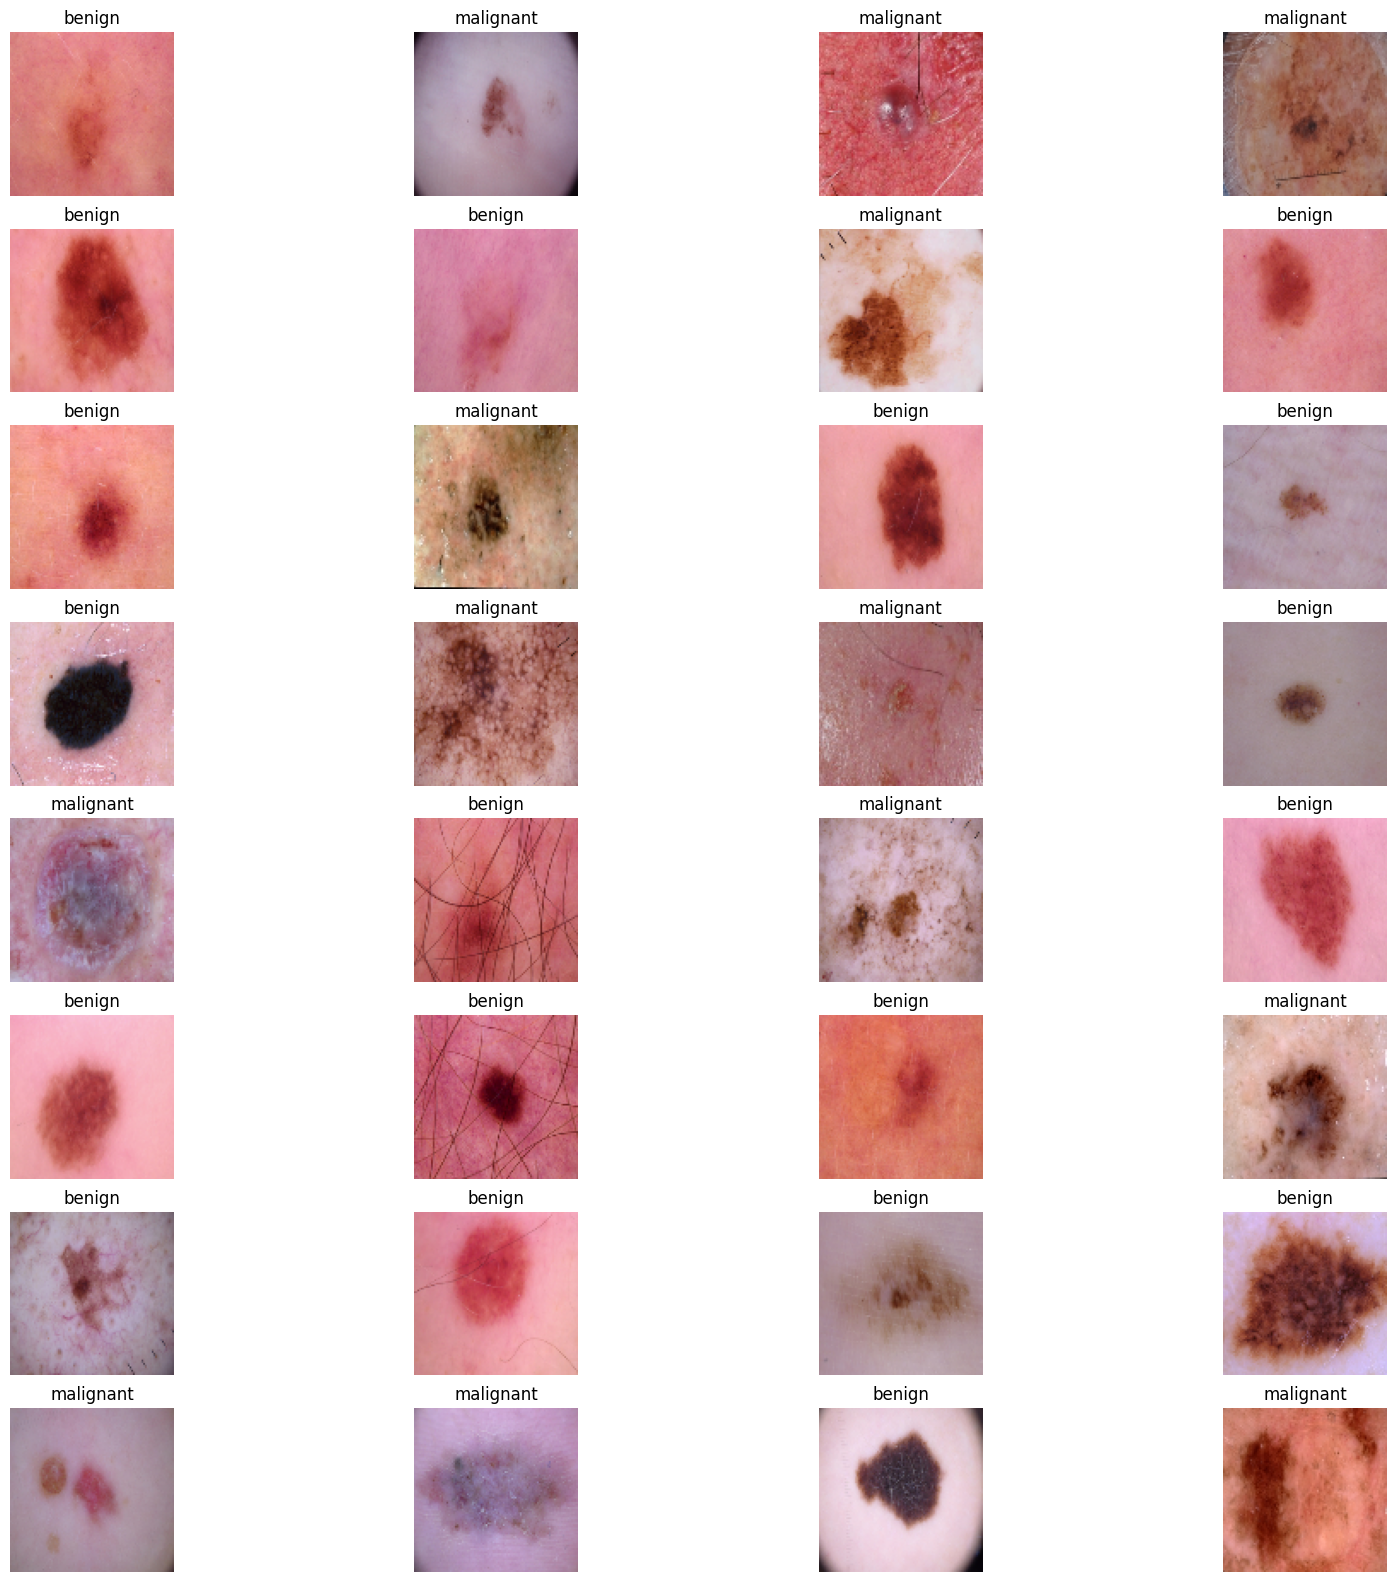

In [34]:
plt.figure(figsize=(20,20))
for n,i in enumerate(list(np.random.randint(1,len(X_train),32))):
  plt.subplot(8,4,n+1)
  plt.imshow(X_train[i])
  plt.axis("off")
  image_class = {0:"benign", 1:"malignant"}
  plt.title(image_class[y_train[i]])
plt.show()

In [35]:
X_train.shape, y_train.shape

((2637, 96, 96, 3), (2637,))

In [36]:
X_test.shape,  y_test.shape

((660, 96, 96, 3), (660,))

In [41]:
print(f"number of malignant (training): {(y_train==1).sum()}")
print(f"number of benign (training): {(y_train==0).sum()}")
print('*'*50)
print(f"number of malignant (testing): {(y_test==1).sum()}")
print(f"number of benign (testing): {(y_test==0).sum()}")

number of malignant (training): 1197
number of benign (training): 1440
**************************************************
number of malignant (testing): 300
number of benign (testing): 360


/tmp/ipython-input-4159239300.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_train,palette="Set2")


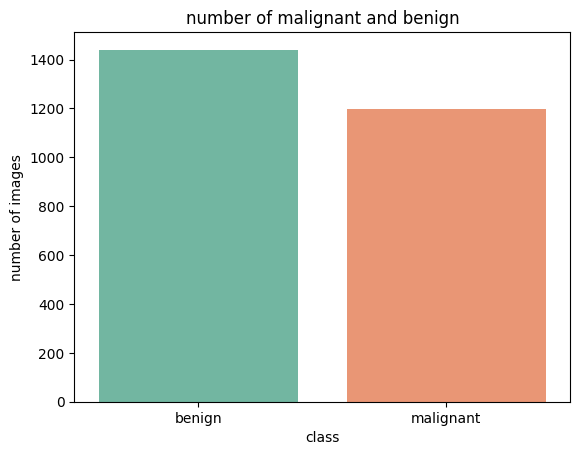

In [38]:
sns.countplot(x=y_train,palette="Set2")
plt.title("number of malignant and benign")
plt.xticks(np.arange(2),["benign","malignant"])
plt.xlabel("class")
plt.ylabel("number of images")
plt.show()

In [39]:
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train)
X_test, y_test = shuffle(X_test, y_test)

In [40]:
X_train = X_train/255.0
X_test  = X_test/255.0

In [42]:
model = keras.models.Sequential([
  keras.layers.Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), activation='relu',padding='same', name='Conv1', input_shape=(96,96,3)),
              keras.layers.MaxPool2D(pool_size=2, strides=1, name='Pool1'),
  keras.layers.Conv2D(filters=128, kernel_size=3, strides=1, activation='relu', name='Conv2', padding='same'),
              keras.layers.MaxPool2D(pool_size=2, strides=1, name='Pool2'),
  keras.layers.Conv2D(filters=256, kernel_size=3, strides=1, activation='relu', name='Conv3', padding='same'),
              keras.layers.MaxPool2D(pool_size=2, strides=1, name='Pool3'),

  keras.layers.Flatten(name='Flatten1'),
  keras.layers.Dense(units=128, activation='relu', name='Dense1'),
  keras.layers.Dense(units=64, activation='relu', name='Dense2'),
  keras.layers.Dense(units=32, activation='relu', name='Dense3'),
  keras.layers.Dense(units=1, activation='sigmoid', name='Output')
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [43]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Conv1 (Conv2D)                  │ (None, 96, 96, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Pool1 (MaxPooling2D)            │ (None, 95, 95, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2 (Conv2D)                  │ (None, 95, 95, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Pool2 (MaxPooling2D)            │ (None, 94, 94, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv3 (Conv2D)                  │ (None, 94, 94, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Pool3 (MaxPooling2D)            │ (None, 93, 93, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatten1 (Flatten)              │ (None, 2214144)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense1 (Dense)                  │ (None, 128)            │   283,410,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense2 (Dense)                  │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense3 (Dense)                  │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 283,791,745 (1.06 GB)

 Trainable params: 283,791,745 (1.06 GB)

 Non-trainable params: 0 (0.00 B)

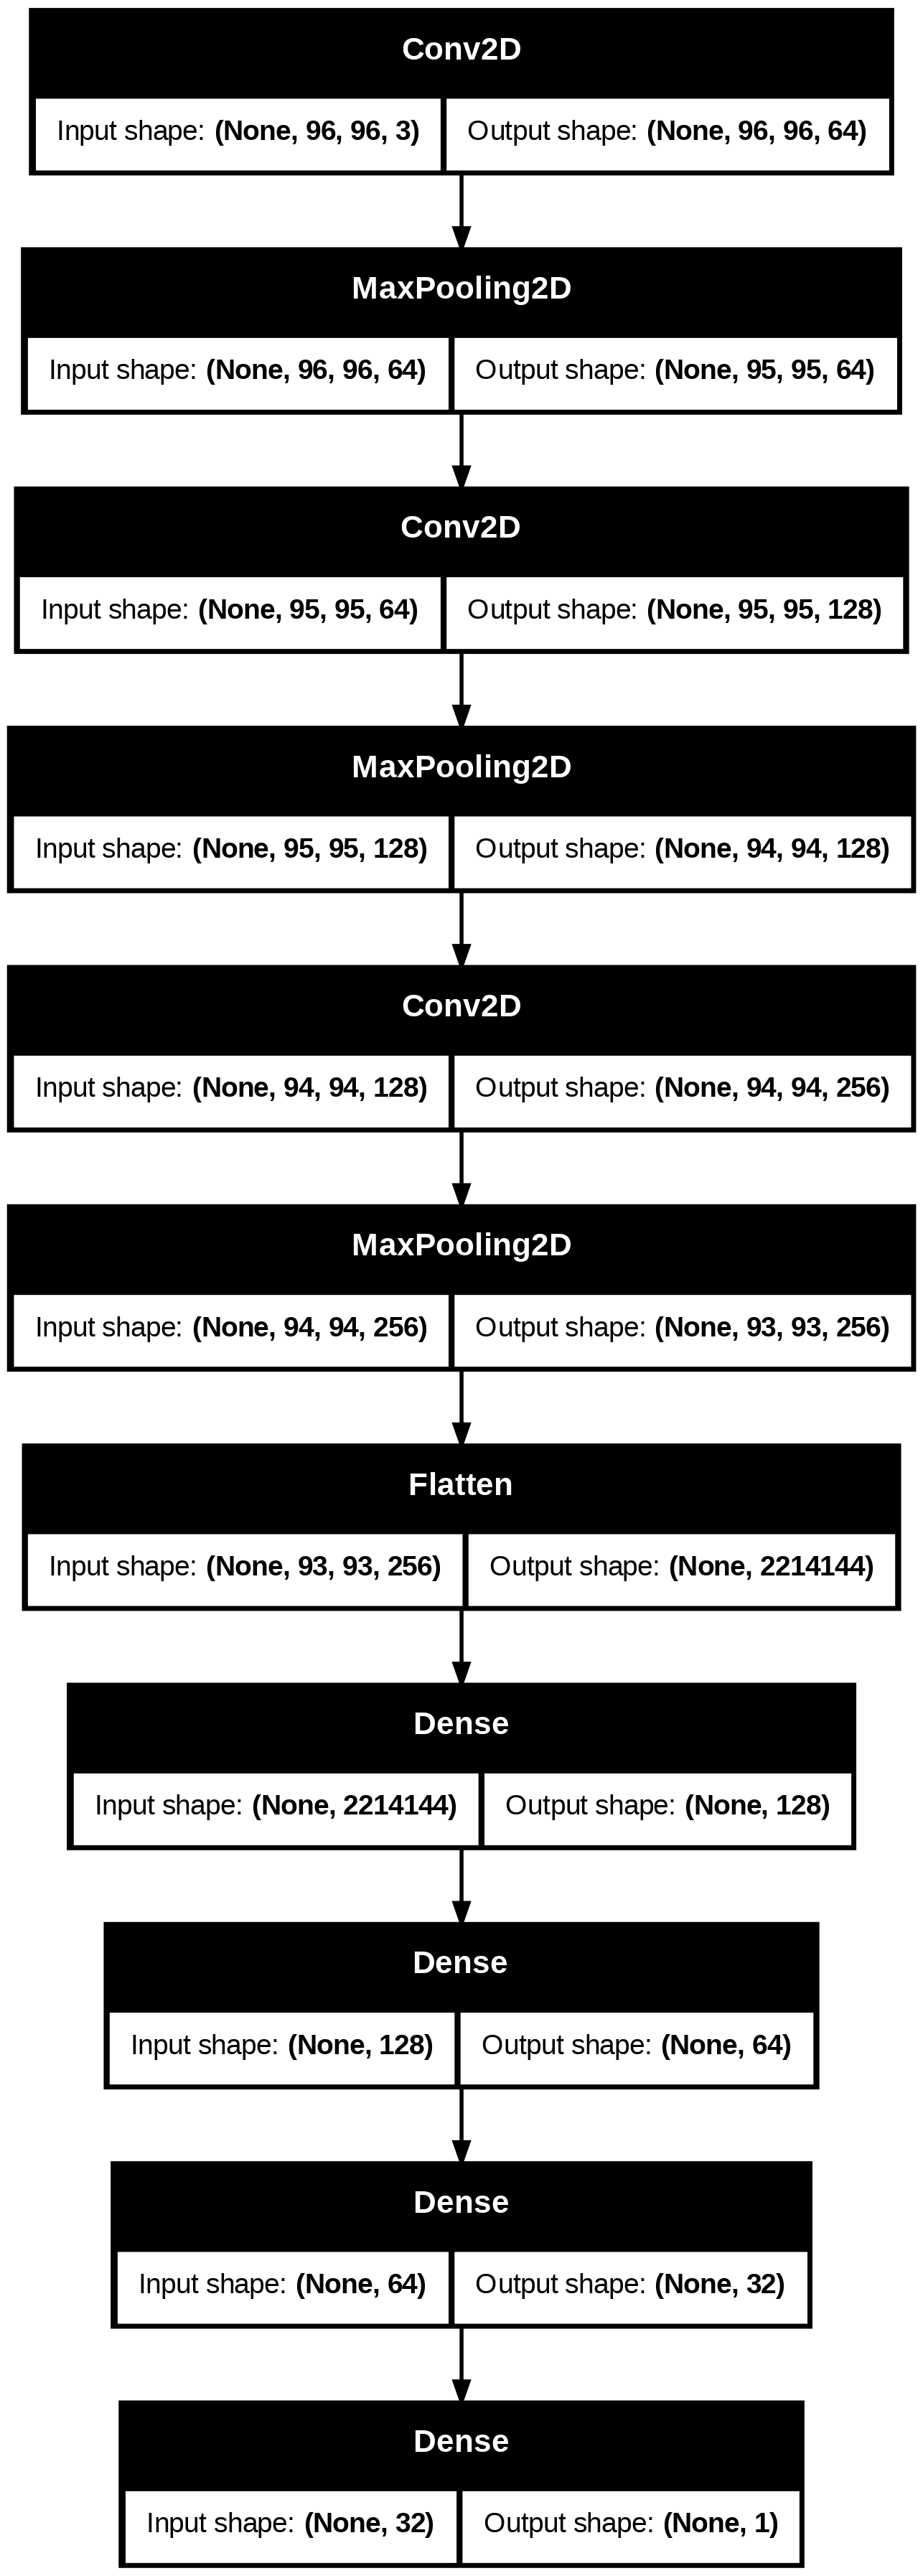

In [48]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True)

In [44]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'recall', 'precision'])

In [45]:
history = model.fit(X_train, y_train, epochs=80, batch_size=16, validation_split=0.2)

Epoch 1/80
132/132 ━━━━━━━━━━━━━━━━━━━━ 52s 263ms/step - accuracy: 0.5333 - loss: 3.9285 - precision: 0.4806 - recall: 0.2942 - val_accuracy: 0.7424 - val_loss: 0.5453 - val_precision: 0.6388 - val_recall: 0.9345
Epoch 2/80
132/132 ━━━━━━━━━━━━━━━━━━━━ 19s 142ms/step - accuracy: 0.7298 - loss: 0.5547 - precision: 0.6608 - recall: 0.8267 - val_accuracy: 0.7860 - val_loss: 0.4564 - val_precision: 0.6758 - val_recall: 0.9738
Epoch 3/80
132/132 ━━━━━━━━━━━━━━━━━━━━ 19s 143ms/step - accuracy: 0.7379 - loss: 0.5243 - precision: 0.6754 - recall: 0.8273 - val_accuracy: 0.7595 - val_loss: 0.5235 - val_precision: 0.8228 - val_recall: 0.5677
Epoch 4/80
132/132 ━━━━━━━━━━━━━━━━━━━━ 19s 144ms/step - accuracy: 0.7048 - loss: 0.5736 - precision: 0.6859 - recall: 0.6686 - val_accuracy: 0.7860 - val_loss: 0.4635 - val_precision: 0.6812 - val_recall: 0.9520
Epoch 5/80
132/132 ━━━━━━━━━━━━━━━━━━━━ 19s 143ms/step - accuracy: 0.7958 - loss: 0.4278 - precision: 0.7296 - recall: 0.8728 - val_accuracy: 0.7519

In [46]:
history.history

{'accuracy': [0.5832148194313049,
  0.7463252544403076,
  0.7178757786750793,
  0.7268847823143005,
  0.7847321033477783,
  0.7937411069869995,
  0.8093883395195007,
  0.8368895053863525,
  0.8368895053863525,
  0.8639165759086609,
  0.8691322803497314,
  0.9094357490539551,
  0.913703203201294,
  0.9122806787490845,
  0.8947368264198303,
  0.9042199850082397,
  0.7619724869728088,
  0.809862494468689,
  0.8624940514564514,
  0.9065908193588257,
  0.9369369149208069,
  0.9355144500732422,
  0.9208155274391174,
  0.9336178302764893,
  0.9625414609909058,
  0.9701279997825623,
  0.9796112179756165,
  0.9871976971626282,
  0.9687055349349976,
  0.8942626714706421,
  0.9867235422134399,
  0.9943100810050964,
  0.9976292252540588,
  0.9981033802032471,
  0.963489830493927,
  0.9596965312957764,
  0.9838786125183105,
  0.9938359260559082,
  0.9976292252540588,
  0.9995258450508118,
  0.9952583909034729,
  0.9890943765640259,
  0.9947842359542847,
  0.9715505242347717,
  0.8952109813690186,
 

In [49]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

precision = history.history['precision']
val_precision = history.history['val_precision']

recall =history.history['recall']
val_recall =history.history['val_recall']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

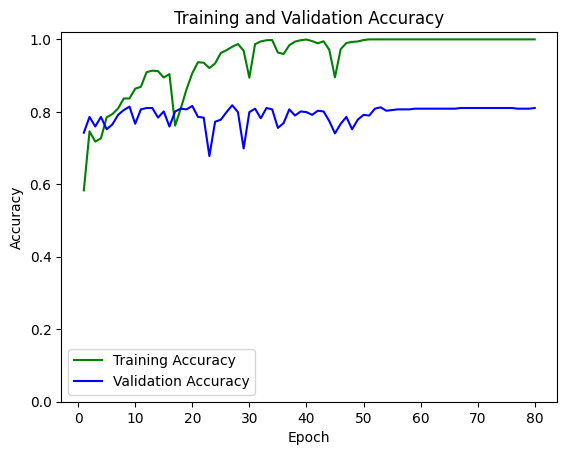

In [50]:
#accuracy plot
plt.plot(epochs, acc, color='green', label='Training Accuracy')
plt.plot(epochs, val_acc, color='blue', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim(0,1.02)
plt.show()

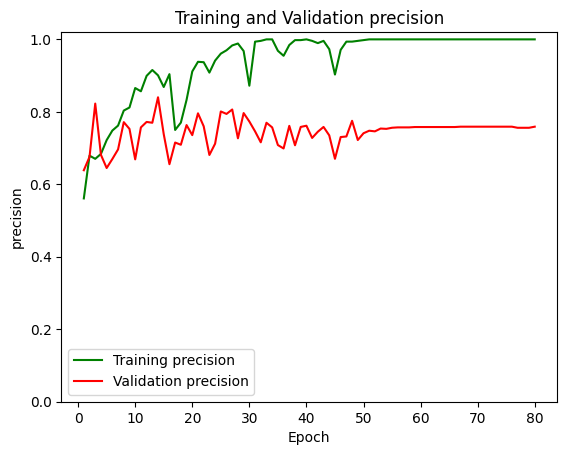

In [51]:
plt.figure()
#loss plot
plt.plot(epochs, precision, color='green', label='Training precision')
plt.plot(epochs, val_precision, color='red', label='Validation precision')
plt.title('Training and Validation precision')
plt.xlabel('Epoch')
plt.ylabel('precision')
plt.legend()
plt.ylim(0,1.02)
plt.show()

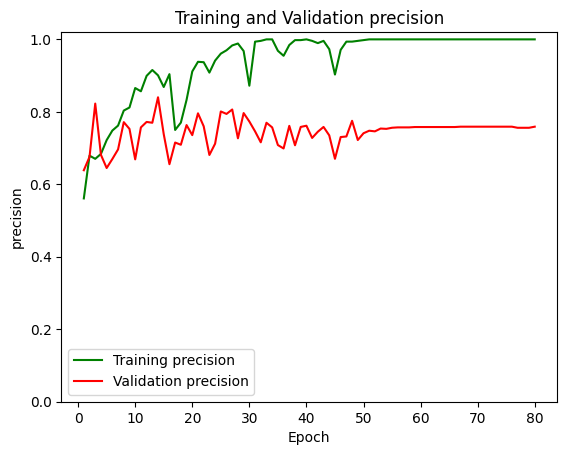

In [52]:
plt.figure()
#loss plot
plt.plot(epochs, precision, color='green', label='Training precision')
plt.plot(epochs, val_precision, color='red', label='Validation precision')
plt.title('Training and Validation precision')
plt.xlabel('Epoch')
plt.ylabel('precision')
plt.legend()
plt.ylim(0,1.02)
plt.show()

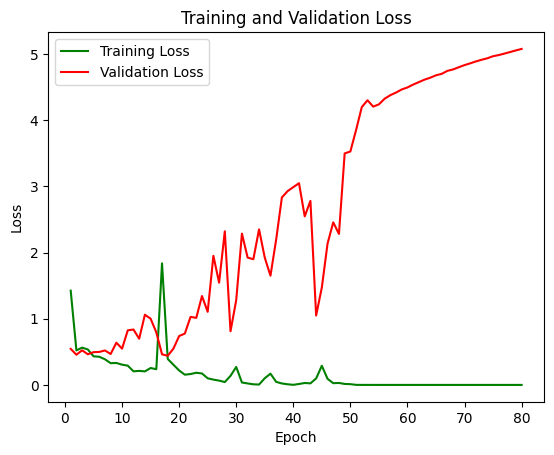

In [53]:
plt.figure()
#loss plot
plt.plot(epochs, loss, color='green', label='Training Loss')
plt.plot(epochs, val_loss, color='red', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [56]:
model_evaluate = model.evaluate(X_test, y_test)
print("Loss     : ",model_evaluate[0])
print("Accuracy : ",model_evaluate[1])
print("Precision  : ",model_evaluate[2])
print("Recall : ",model_evaluate[3])

21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.8125 - loss: 3.2135 - precision: 0.7814 - recall: 0.8336
Loss     :  3.6594982147216797
Accuracy :  0.810606062412262
Precision  :  0.8266666531562805
Recall :  0.7725856900215149


In [57]:
from sklearn.metrics import confusion_matrix, classification_report
y_pred = model.predict(X_test)
y_pred = np.where(y_pred>0.5,1,0)
print(classification_report(y_test, y_pred))

21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 87ms/step
              precision    recall  f1-score   support

           0       0.85      0.80      0.82       360
           1       0.77      0.83      0.80       300

    accuracy                           0.81       660
   macro avg       0.81      0.81      0.81       660
weighted avg       0.81      0.81      0.81       660



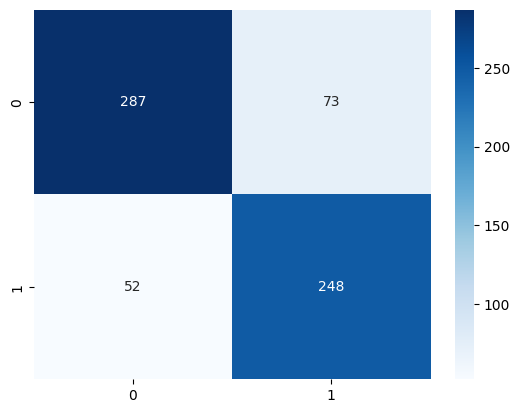

In [59]:
sns.heatmap(confusion_matrix(y_test, y_pred), fmt="g", annot=True, cmap='Blues')
plt.show()

In [60]:
model.save("my_model.h5")